# Exercise 9.1: Linear regression

Assume we are given a dataset of pairs $(t_1,z_1),\dots,(t_n,z_n) \in \mathbb{R}^2$ with some $n\in\mathbb{N}$. The values of $z_i$ are measurements of a parameter of a certain system at time points $t_i$, $i=1,\dots,n$. We assume that there is an (approximately) linear dependence between $z_i$'s and $t_i$'s, i.e. we have

$$z_i = \alpha t_i + \beta, \quad i=1,\dots,n$$

for some $\alpha,\beta\in\mathbb{R}$. How can we find the appropriate values for $\alpha$ and $\beta$?

Consider the [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) problem 

$$\min_{\alpha,\beta\in\mathbb{R}}  \sum_{i=1}^n (z_i - \alpha t_i - \beta)^2, $$

i.e. the minimization of squared distances from the line $z = \alpha t + \beta$ to the data points. We can solve this problem as follows:

**a)** Find gradient $G$ and the Hessian matrix $H$ of the following function:

$$f(\alpha,\beta) = \sum_{i=1}^n (z_i - \alpha t_i - \beta)^2$$

In [1]:
import sympy as sym
from sympy.abc import alpha, beta, i
sym.init_printing()

In [2]:
n = sym.Symbol('n', integer=True)

# define z_i and t_i as indexed variables
z= sym.IndexedBase('z')
t= sym.IndexedBase('t', positive=True)
i = sym.symbols('i', cls=sym.Idx)
z_i= z[i]
t_i= t[i]

# define summ over index i
S_n = sym.Sum((z_i-alpha*t_i-beta)**2,(i,1,n))

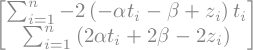

In [3]:
# Gradient 
G = sym.Matrix([S_n.diff(j) for j in (alpha,beta)])

G

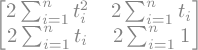

In [4]:
# Hessian 
M = sym.simplify(sym.hessian(S_n,[alpha, beta]))

# Alternatively, you can calculate the Hessian using differentiation
# M=sym.Matrix([G.diff(j) for j in (alpha,beta)]).reshape(2,2)

M

**b)** Find the point(s) where the gradient is equal to zero. One way to do it for a quadratic function is to solve the following matrix equation:

$$H \begin{bmatrix}
           \alpha \\
           \beta
         \end{bmatrix} = - G|_{\alpha=0,\beta=0}$$

for $(\alpha, \beta)$ (you can use `H.LUsolve` method). Alternatively, you can try to directly solve the equation $G = 0$ using different [sympy solvers](https://docs.sympy.org/latest/modules/solvers/solvers.html#solvers-algebraic-equations).

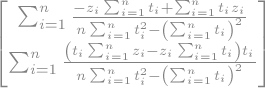

In [5]:
# solve the linear system
sol = sym.simplify(M.LUsolve(-G.subs([(alpha,0),(beta,0)])))

sol

# you can compare the solution with the known solution of simple linear regression problem

**c)** To check whether the point(s) with $G=0$ are minima/maxima, we need to check if the hessian is positive/negative definite. Try checking positive definiteness of $H$ using sympy. You will see that sympy methods cannot directly determine whether $H$ is positive definite in our case. Thus, calculate the determinant of $H$ and observe that it is positive by [Cauchy-Schwarz inequality](https://en.wikipedia.org/wiki/Cauchy–Schwarz_inequality). As the first leading principal minor of $H$ is also positive, we have positive-definiteness by [Sylvester's criterion](https://en.wikipedia.org/wiki/Sylvester%27s_criterion).

In [6]:
# First, we can try several sympy functions to check if H is positive definite
display(M.is_positive_definite)
display(M.det().is_positive)
display([i.is_positive for i in M.eigenvals().keys()])
v  = sym.Matrix(2,1,sym.symbols('v1:3'))
display(sym.simplify(v.T*M*v)[0].is_positive)

# We see that none of these methods can determine whether H is positive definite

None

None

[None, None]

None

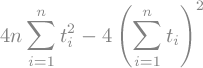

In [7]:
# Instead, we compute the determinant of H

sym.simplify(M.det())

# We see that the determinant is strictly positive by Cauchy-Schwarz inequality (given that t_i have different values)
# Thus, M is positive-definite by Silvester's criterion

# Exercise 9.2: Gambler's Ruin

Consider the following two-player game. Alice and Bob toss a fair coin. In case of heads, Alice gets one euro from Bob, otherwise Bob gets one euro from Alice. Alice starts with 2 euros. The game ends if Alice has 4 euros or if she has lost money. This game can be illustrated by the following state graph, where the numbers indicate how much money Alice currently has and the arrows indicate the transition probabilities.

![](game.png)

**a)** Generate the transition matrix $M$, where $M_{i,j}$ is the probability to transition from state $i$ to state $j$.

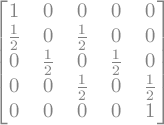

In [8]:
N = 5 # the number of states

half = sym.Rational(1,2)

# We can generate a matrix using a lambda function
M = sym.Matrix(N,N, lambda i,j: 
                   1 if (( j == 0 and i== 0) or (j == N-1 and i== N-1))
                   else half if (i > 0 and i < N-1 and j == i-1)
                   else half if (i > 0 and i < N-1 and j == i+1)
                   else 0
                   )

M

**b)** The Matix power $M^t$ given the transition probabilities after $t$ rounds. Determine $M^\infty = \lim_{t\to\infty} M^t$.

*Hint: You can diagonalize $M$ and find the limit of the diagonal matrix componentwise.*

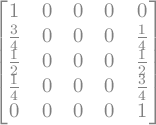

In [9]:
# diagonalize the matrix M
V,D = M.diagonalize()

# find limits of the diagonal elements and form the limit of the diagonal matrix
D_lim = sym.diag(*[sym.limit_seq(D[i,i]**n,n) for i in range(N)])

# use the limit of D to find the limit of M
M_lim = V*D_lim*V**-1  

M_lim

**c)** Determine the probability that Alice will go bankrupt. To do so, create a vector $v=[0,0,1,0]$ and calculate $vM^\infty$.

In [10]:
m = 2 # the index of the initial state (state 2 has index 2 in our case)

v = sym.Matrix(1,N, lambda i,j: 1 if j==m else 0 )

(v*M_lim)[0]

**d)** What happens with the probability of bankruptcy is the game ends not when Alice has 4 euros but when she has 5 or 6 euros?

In [11]:
# Running the code above for N=5,6,7,etc. shows that the probability of bankruptcy increases with N